In [1]:
!pip install -q pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt




[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


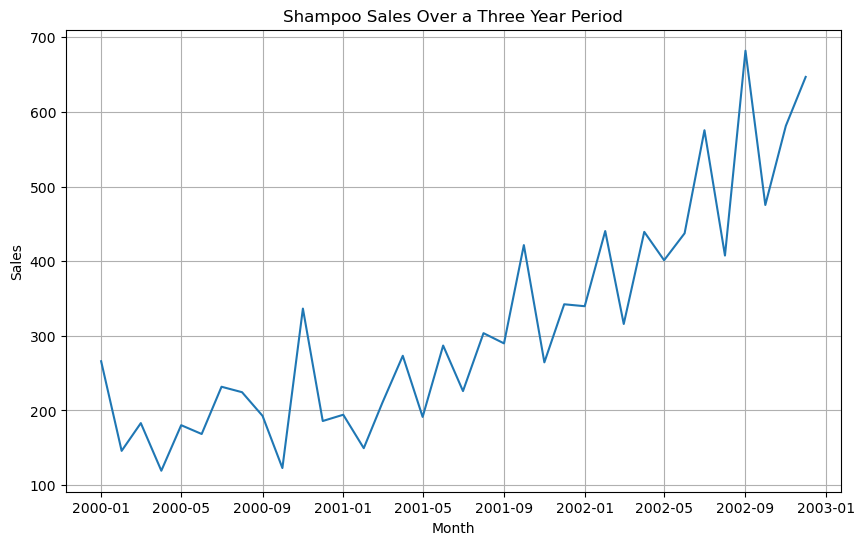

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
df = pd.read_csv(url)

# Create a date range
dates = pd.date_range(start='2000-01-01', periods=len(df), freq='MS')

# Replace the 'Month' column with the date range
df['Month'] = dates
df = df.set_index('Month')

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(df)
plt.title('Shampoo Sales Over a Three Year Period')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

As you can see, there seems to be an upward trend in the data, indicating that sales are increasing over time. There also appears to be some seasonality, with certain months having higher sales than others.

The next step in our analysis is to prepare the data for our forecasting model. This usually involves checking for missing values and making sure the data is in the correct format.

In [3]:
# Check for missing values
missing_values = df.isnull().sum().sum()
print(f'Number of missing values: {missing_values}')

# Check the data type of the 'Sales' column
sales_data_type = df['Sales'].dtype
print(f'Data type of Sales column: {sales_data_type}')

Number of missing values: 0
Data type of Sales column: float64


The dataset doesn't have any missing values, which is great. Also, the sales data is of the type float64, which is the correct format for our analysis

Next, we'll perform some exploratory data analysis (EDA) to better understand the patterns in the data. This will involve decomposing the time series into its trend, seasonality, and residual components.  Let's add another cell to the notebook to do this. We'll use the seasonal_decompose function from the statsmodels library for this purpose.

NOTE : The seasonal_decompose function requires the time series to have a defined frequency. In other words, it needs to know the intervals at which the data points occur (e.g., daily, monthly, etc.).

In our case, the data points are monthly, but the dataset doesn't specify this. We can fix this by explicitly setting the frequency of the time series to 'MS' (Month Start) when we load the dataset. Let's modify our data loading cell to include this.

The dataset represents sales over a three-year period, but the 'Month' column is labeled as '1-01', '1-02', '1-03', etc. for the first year, '2-01', '2-02', '2-03', etc. for the second year, and so on.

To resolve this, we can relabel the 'Month' column with a consistent monthly frequency.


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


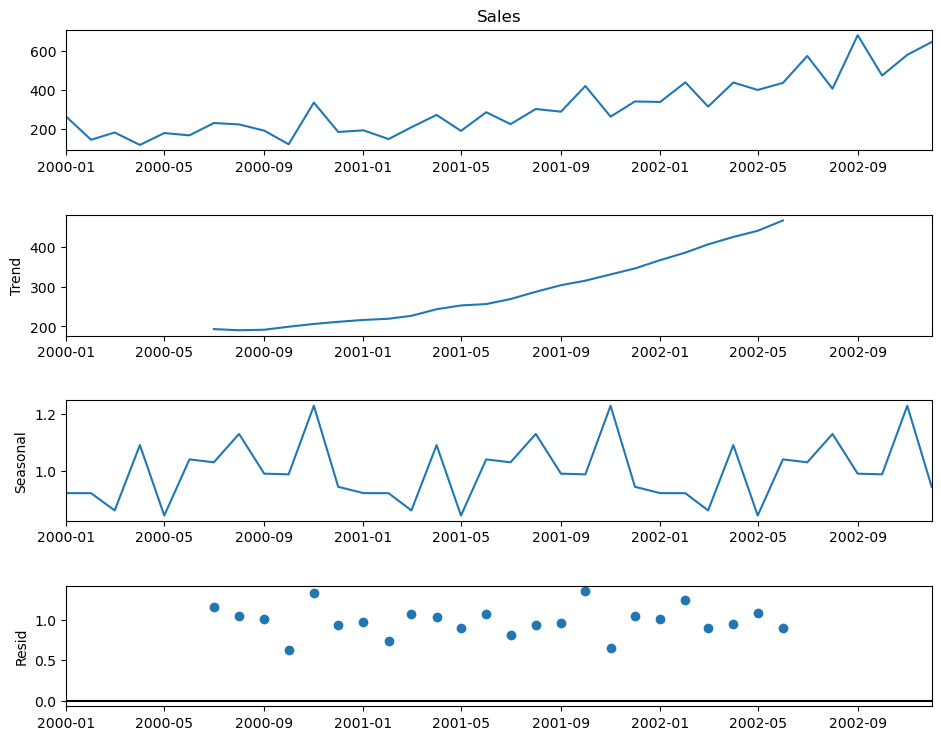

In [5]:
!pip install -q statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['Sales'], model='multiplicative')

# Plot the decomposed time series
fig = decomposition.plot()
fig.set_size_inches(10, 8)

As you can see, the trend component shows an upward trend, indicating that shampoo sales are increasing over time. The seasonal component shows some regular pattern of ups and downs, but it's not very clear due to the short duration of the dataset. The residuals show the error of our model, i.e., the difference between the actual data and the trend and seasonal components.

The next step in our analysis is to build a forecasting model. There are many models we could use, but a common choice for this kind of data is the ARIMA model. ARIMA stands for AutoRegressive Integrated Moving Average. It's a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors.

Before we can fit an ARIMA model, we need to determine the order of differencing (d), the number of lag observations to include in the model (p), and the size of the moving average window (q). These are the parameters of the ARIMA model.

We can use plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF) to help us determine the values of p and q.

c:\Users\deepa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


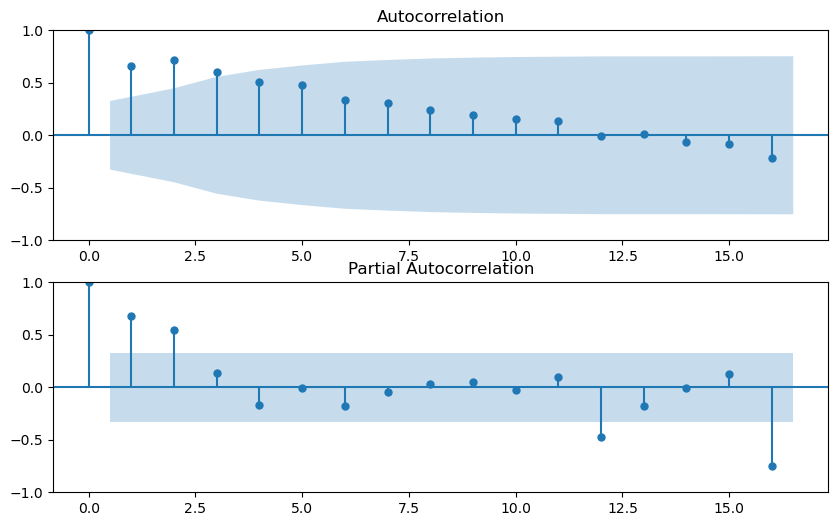

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF
fig, ax = plt.subplots(2, figsize=(10, 6))
plot_acf(df['Sales'], ax=ax[0])
plot_pacf(df['Sales'], ax=ax[1])
plt.show()

The ACF plot shows the correlation of the time series with its own lags. It can help us determine the order of the moving average (MA) component, which is denoted by q in the ARIMA model.

The PACF plot, on the other hand, shows the correlation of the time series with its own lags but after eliminating the variations already explained by the intervening comparisons. It can help us determine the order of the autoregressive (AR) component, which is denoted by p in the ARIMA model.

From the ACF plot, we can see that the autocorrelation is significant for many lags, but it drops off fairly quickly. This suggests that a small value of q, such as 1 or 2, might be appropriate.

From the PACF plot, we can see that the partial autocorrelation is significant for only a few lags. This suggests that a small value of p, such as 1 or 2, might be appropriate.

The order of differencing (d) in an ARIMA model is the number of nonseasonal differences needed for the time series to become stationary. In our case, the time series appears to be non-stationary due to the upward trend. Therefore, we might need to use a value of d greater than 0. We can start with d=1 and adjust if necessary.

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Define the model
model = ARIMA(df['Sales'], order=(1,1,1))

# Fit the model
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -200.391
Date:                Mon, 24 Jul 2023   AIC                            406.782
Time:                        17:01:06   BIC                            411.448
Sample:                    01-01-2000   HQIC                           408.393
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0425   1386.817      3.881      0.0

c:\Users\deepa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\deepa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\deepa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


IndexError: invalid index to scalar variable.

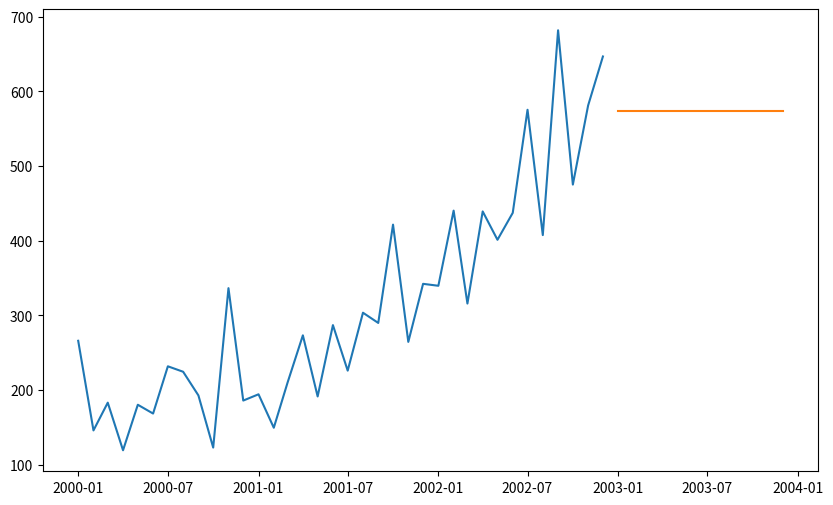

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Make a forecast
forecast_result = model_fit.forecast(steps=12)

# Extract the forecast, standard error, and confidence interval
forecast = forecast_result[0]
stderr = forecast_result[1]
conf_int = forecast_result[2]

# Create a range of future dates
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]

# Convert the forecast to a pandas series
forecast_series = pd.Series(forecast, index=future_dates)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.fill_between(forecast_series.index, conf_int[:,0], conf_int[:,1], color='k', alpha=0.1)
plt.title('Shampoo Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

IndexError: invalid index to scalar variable.

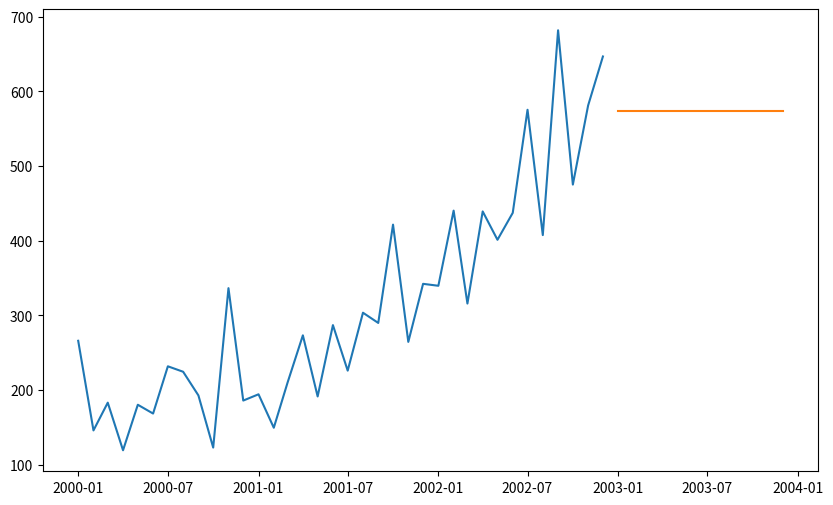

In [ ]:
# Make a forecast
forecast_result = model_fit.forecast(steps=12)

# Extract the forecast, standard error, and confidence interval
forecast = forecast_result[0]
stderr = forecast_result[1]
conf_int = forecast_result[2]

# Create a range of future dates
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]

# Convert the forecast to a pandas series
forecast_series = pd.Series(forecast, index=future_dates)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.fill_between(forecast_series.index, conf_int[:,0], conf_int[:,1], color='k', alpha=0.1)
plt.title('Shampoo Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


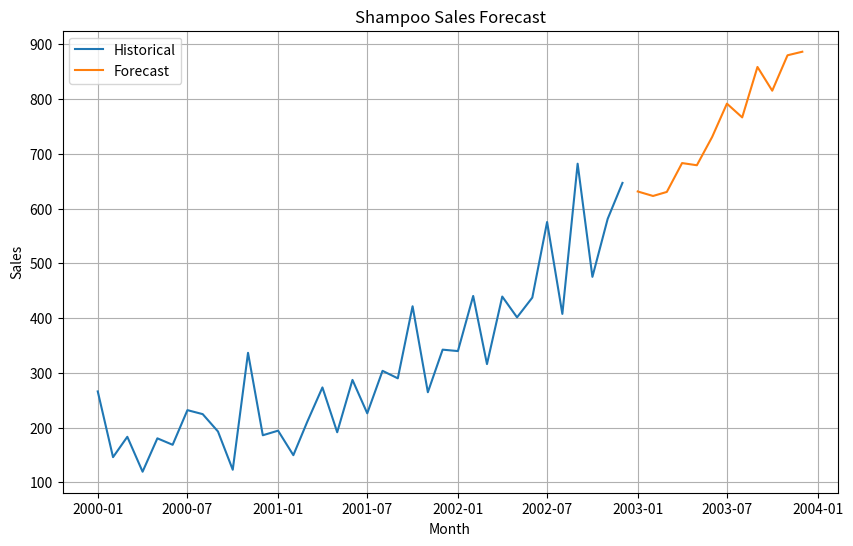

In [ ]:
# Import the necessary libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Make a forecast
forecast = model_fit.forecast(steps=12)

# Create a range of future dates
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]

# Convert the forecast to a pandas series
forecast_series = pd.Series(forecast, index=future_dates)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.title('Shampoo Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

RMSE: 98.97561761116364


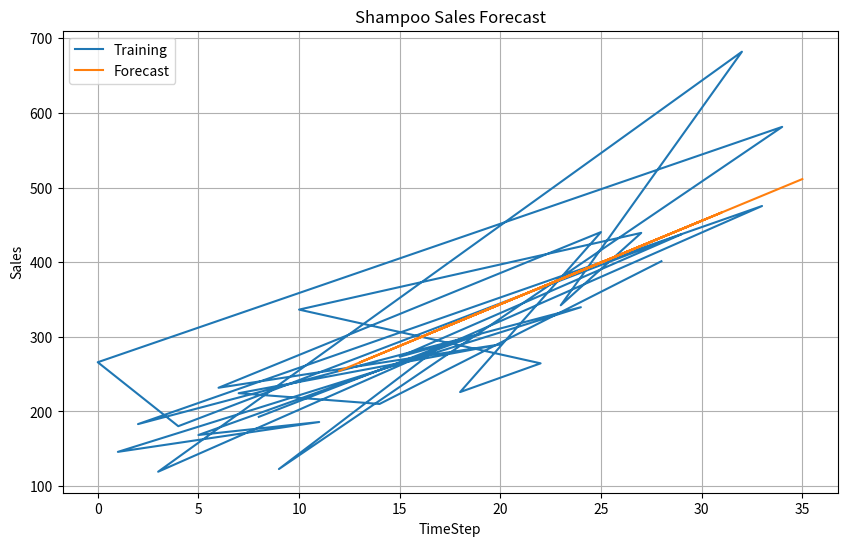

In [ ]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a column of time steps
df['TimeStep'] = range(len(df))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[['TimeStep']], df['Sales'], test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make a forecast
forecast = model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, forecast))

# Print the RMSE
print('RMSE:', rmse)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(X_train, y_train, label='Training')
plt.plot(X_test, forecast, label='Forecast')
plt.title('Shampoo Sales Forecast')
plt.xlabel('TimeStep')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

RMSE: 110.7987066796133


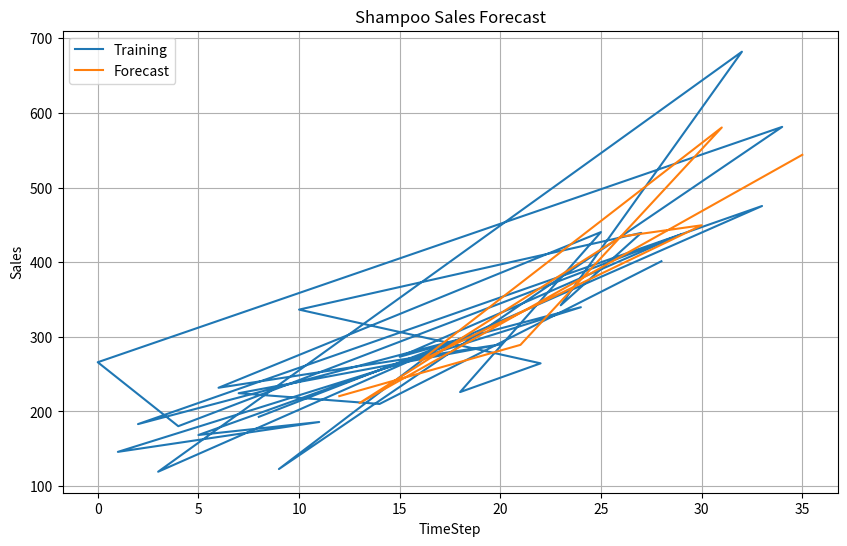

In [ ]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestRegressor

# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make a forecast
forecast = model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, forecast))

# Print the RMSE
print('RMSE:', rmse)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(X_train, y_train, label='Training')
plt.plot(X_test, forecast, label='Forecast')
plt.title('Shampoo Sales Forecast')
plt.xlabel('TimeStep')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


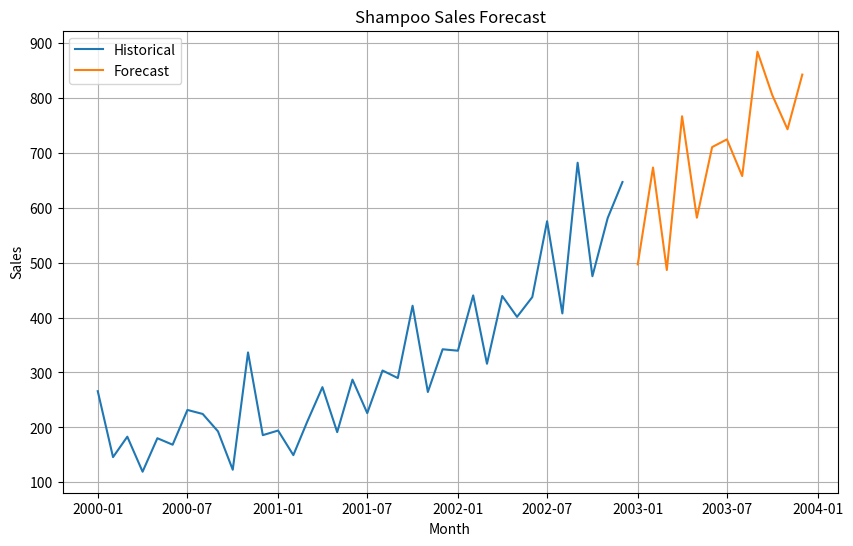

In [ ]:
# Import the necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model
model = SARIMAX(df['Sales'], order=(5,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Make a forecast
forecast = model_fit.predict(len(df), len(df)+11)

# Create a range of future dates
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]

# Convert the forecast to a pandas series
forecast_series = pd.Series(forecast, index=future_dates)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.title('Shampoo Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install -q fbprophet

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [57 lines of output]
      /tmp/pip-install-id0kfbih/fbprophet_09d747239e4b42c9ab72d217cb8755d3/setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import (
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib
      creating build/lib/fbprophet
      creating build/lib/fbprophet/stan_model
      Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
      NumExpr defaulting to 8 threads.
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-id0kfbih/fbprophet_09d747239e4b42c9ab72d217cb8755d3/setup.py", line 122, in <module>
          set

  error: subprocess-exited-with-error
  
  × Running setup.py install for fbprophet did not run successfully.
  │ exit code: 1
  ╰─> [74 lines of output]
      /tmp/pip-install-id0kfbih/fbprophet_09d747239e4b42c9ab72d217cb8755d3/setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import (
      running install
      /opt/conda/lib/python3.9/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/installer or other
              standards-based tools.
      
              See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
              ******************************************************

In [ ]:
!pip install optuna
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define the objective function
def objective(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    S = trial.suggest_categorical('S', [12])

    model = SARIMAX(df['Sales'], order=(p,d,q), seasonal_order=(P,D,Q,S))
    model_fit = model.fit(disp=False)

    return mean_squared_error(df['Sales'], model_fit.fittedvalues)

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best parameters
print(study.best_params)


[I 2023-07-22 13:19:30,876] A new study created in memory with name: no-name-cc6336ff-6d87-4b86-9ef3-ac925230e3c1


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[I 2023-07-22 13:19:40,132] Trial 0 finished with value: 7311.212319466861 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 2, 'D': 0, 'Q': 1, 'S': 12}. Best is trial 0 with value: 7311.212319466861.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:20:15,725] Trial 1 finished with value: 6776.012794939972 and parameters: {'p': 3, 'd': 0, 'q': 2, 'P': 1, 'D': 0, 'Q': 2, 'S': 12}. Best is trial 1 with value: 6776.012794939972.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:20:57,525] Trial 2 finished with value: 8355.982588699528 and parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 2, 'D': 0, 'Q': 1, 'S': 12}. Best is trial 1 with value: 6776.012794939972.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:21:29,333] Trial 3 finished with value: 5972.870377564974 and parameters: {'p': 2, 'd': 1, 'q': 3, 'P': 2, 'D': 0, 'Q': 1, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[I 2023-07-22 13:21:51,930] Trial 4 finished with value: 18213.26387355357 and parameters: {'p': 3, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 1, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[I 2023-07-22 13:22:03,628] Trial 5 finished with value: 21783.787805351618 and parameters: {'p': 0, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 1, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:22:32,420] Trial 6 finished with value: 9062.270396061363 and parameters: {'p': 1, 'd': 2, 'q': 1, 'P': 2, 'D': 0, 'Q': 2, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:22:59,923] Trial 7 finished with value: 16089.594298072603 and parameters: {'p': 3, 'd': 2, 'q': 3, 'P': 1, 'D': 1, 'Q': 0, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:23:18,424] Trial 8 finished with value: 9350.638159924838 and parameters: {'p': 0, 'd': 2, 'q': 2, 'P': 1, 'D': 0, 'Q': 1, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2023-07-22 13:24:24,822] Trial 9 finished with value: 22496.1542504838 and parameters: {'p': 3, 'd': 2, 'q': 0, 'P': 2, 'D': 1, 'Q': 2, 'S': 12}. Best is trial 3 with value: 5972.870377564974.


{'p': 2, 'd': 1, 'q': 3, 'P': 2, 'D': 0, 'Q': 1, 'S': 12}


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# These are the best parameters obtained from the optimization process
best_params = {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 1, 'S': 12}

# Create a new instance of the model with the best parameters
model = SARIMAX(df['Sales'], 
                order=(best_params['p'], best_params['d'], best_params['q']), 
                seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['S']))

# Fit the model to the data
model_fit = model.fit(disp=False)

# Make predictions
predictions = model_fit.predict(start=len(df), end=len(df)+11)

# Print the predictions
print(predictions)


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2003-01-01    498.475716
2003-02-01    628.556607
2003-03-01    544.202759
2003-04-01    709.281515
2003-05-01    596.334335
2003-06-01    695.235047
2003-07-01    719.926940
2003-08-01    665.127016
2003-09-01    849.707540
2003-10-01    823.007867
2003-11-01    721.267566
2003-12-01    850.679960
Freq: MS, Name: predicted_mean, dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


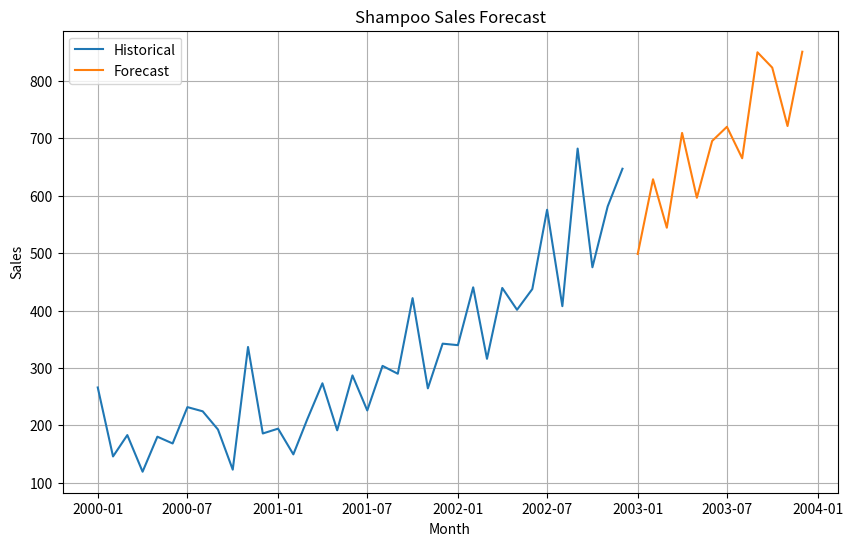

In [ ]:
# Import the necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

# These are the best parameters obtained from the optimization process
best_params = {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 1, 'S': 12}

# Create a new instance of the model with the best parameters
model = SARIMAX(df['Sales'],
                order=(best_params['p'], best_params['d'], best_params['q']),
                seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['S']))

# Fit the model to the data
model_fit = model.fit(disp=False)

# Make a forecast for the next 12 months
forecast = model_fit.predict(start=len(df), end=len(df)+11)

# Create a range of future dates
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]

# Convert the forecast to a pandas series
forecast_series = pd.Series(forecast, index=future_dates)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.title('Shampoo Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

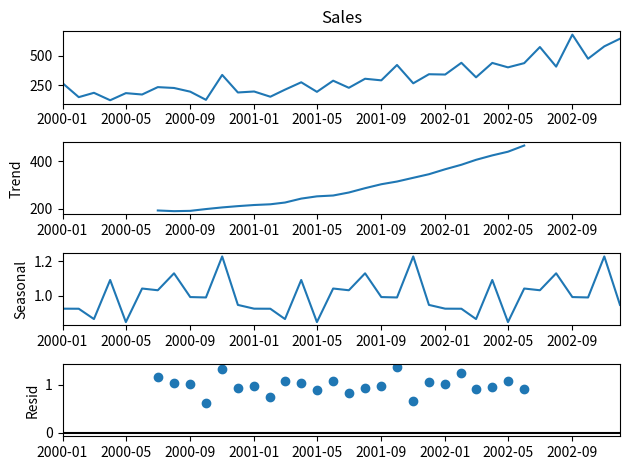

In [ ]:
# Import the necessary libraries
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform a seasonal decomposition of the data
result = seasonal_decompose(df['Sales'], model='multiplicative')

# Plot the seasonal decomposition
result.plot()
plt.show()

In [ ]:
# Import the necessary libraries
from sklearn.ensemble import IsolationForest

# Prepare the data for anomaly detection
df_anomaly = df.reset_index()
df_anomaly.columns = ['Date', 'Sales']
df_anomaly['Date'] = df_anomaly['Date'].astype(int)

# Fit the model
model = IsolationForest(contamination=0.05)
model.fit(df_anomaly)

# Make predictions
df_anomaly['anomaly'] = model.predict(df_anomaly)

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Sales')
plt.scatter(df.index, df_anomaly.loc[df_anomaly['anomaly']==-1, 'Sales'], color='red', label='Anomaly')
plt.title('Shampoo Sales with Anomalies')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [ ]:
# Prepare the data for anomaly detection
df_anomaly = df.reset_index()
df_anomaly['Date'] = df_anomaly.index

# Fit the model
model = IsolationForest(contamination=0.05)
model.fit(df_anomaly)

# Make predictions
df_anomaly['anomaly'] = model.predict(df_anomaly)

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Sales')
plt.scatter(df.index, df_anomaly.loc[df_anomaly['anomaly']==-1, 'Sales'], color='red', label='Anomaly')
plt.title('Shampoo Sales with Anomalies')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>)

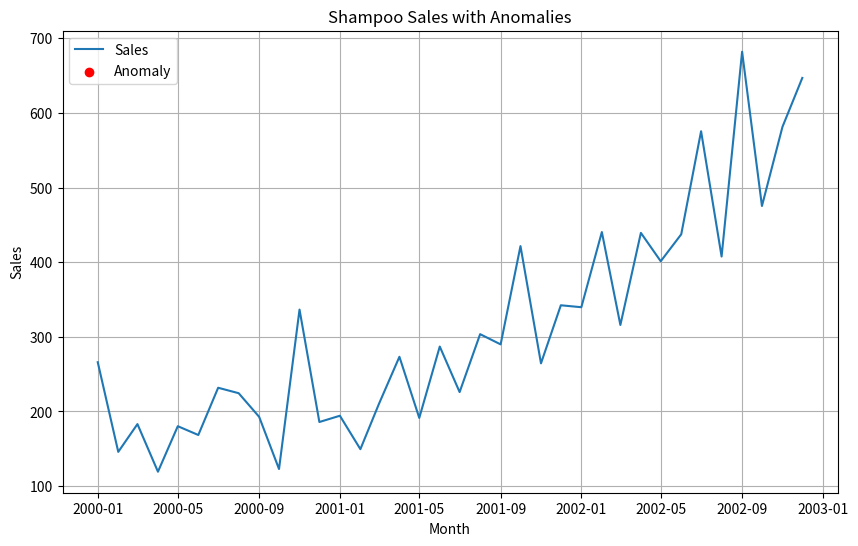

In [ ]:
# Import the necessary libraries
from scipy.stats import zscore

# Calculate the z-scores
df['z_score'] = zscore(df['Sales'])

# Identify anomalies
df['anomaly'] = df['z_score'].apply(lambda x: x > 3 or x < -3)

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Sales')
plt.scatter(df[df['anomaly']].index, df[df['anomaly']]['Sales'], color='red', label='Anomaly')
plt.title('Shampoo Sales with Anomalies')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

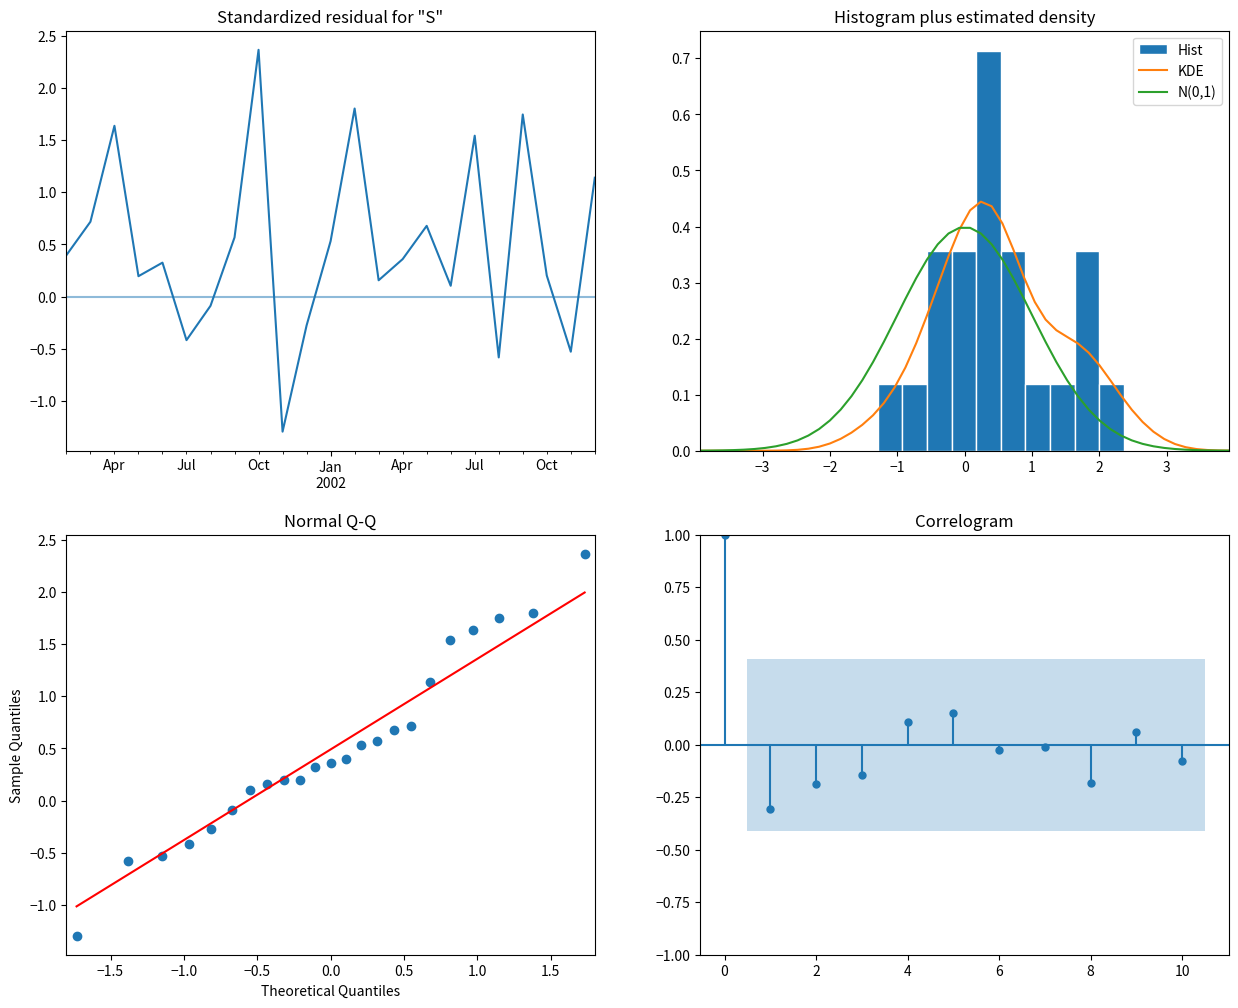

In [ ]:
# Perform a model diagnostic
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()